In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_absolute_error, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Лабораторная №2 - Проведение исследований с алгоритмом Линейная и Логистическая регрессия

## 1.Выбор начальных условий

In [6]:
pd.options.display.max_columns = None
data_classification = pd.read_csv('class_data/stackoverflow_full.csv').drop('Unnamed: 0', axis=1) #Выгрузка csv с данными классификации

files = ['FOOD-DATA-GROUP1.csv', 'FOOD-DATA-GROUP2.csv', 'FOOD-DATA-GROUP3.csv', 'FOOD-DATA-GROUP4.csv', 'FOOD-DATA-GROUP5.csv']
data_reg = pd.concat((pd.read_csv(f'reg_data/{f}') for f in files), ignore_index=True).drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1) #объединение и выгрузка сразу всех файлов с данными регрессии

Для оценки качества Классификации будем использовать такие же метрики как в прошлой работе: 
- Accuracy (Процент правильных предсказаний)
- F1-Score (важная метрика если классы несбалансированны)
- Confusion Matrix (Матрица которая покажет полную карту в работе модели)

Для оценки качества Регрессии будем использовать такие же базовые метрики как и в прошлой работе:

- RMSE (показывает типичный размер ошибки в исходных единицах) 
- MAE (устойчива к выбросам)
- R^2 (показывает общее качество модели)

## 2.Создание бейзлайна и оценка качества

Перед созданием и обучением модели, нам надо немного почистить и закодировать данные в датафрейме Классификации, тк модель не сможет работать с object признаками. Датафрейм регрессии уже готов для обучения модели.

In [13]:
def encoder_data(data: pd.DataFrame):
    onehot = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    Ordinal = OrdinalEncoder()
    
    if 'HaveWorkedWith' in data.columns:
        tech_dummies = data['HaveWorkedWith'].str.get_dummies(sep=';')
        data = pd.concat([data, tech_dummies], axis=1)
        data = data.drop('HaveWorkedWith', axis=1)
    
    categorical_features = data.select_dtypes(include=['object']).columns
    for col in categorical_features:
        
        if data[col].nunique() == 2:
            col_encoded = onehot.fit_transform(data[[col]])
            col_df = pd.DataFrame(col_encoded, columns=onehot.get_feature_names_out([col]))
            data = pd.concat([data.drop(col, axis=1), col_df], axis=1)
            
        else:
            col_encoded = Ordinal.fit_transform(data[[col]])
            col_df = pd.DataFrame(col_encoded, columns=Ordinal.get_feature_names_out([col]))
            data = pd.concat([data.drop(col, axis=1), col_df], axis=1)
    return data

data_classification_encoded = encoder_data(data_classification)

После всей кодировки данных перейдём к обучению моделей. Разделим данные на тренировочные и тестовые для обучения и проверки метрик на данных которые модель ещё не видела и приступим к обучению

In [15]:
y_classification = data_classification_encoded['Employed']
x_classification = data_classification_encoded.drop('Employed', axis = 1)

y_reg = data_reg['Nutrition Density']
x_reg = data_reg.drop(['Nutrition Density','food'], axis=1)

X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(x_classification, y_classification, test_size=0.33, 
                                                                                                                random_state=42) # разделение данных на тестовые и обучающие выборки

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.33, random_state=42)

classification_model = LogisticRegression() #модель Логистической регрессии для классификации
Reg_model = LinearRegression() #Модель Линейной регрессии 

classification_model_fit = classification_model.fit(X_train_classification, y_train_classification) # обучение модели Классификации
Reg_model_fit = Reg_model.fit(X_train_reg, y_train_reg) # Обучение модели Регрессии

classification_predict = classification_model_fit.predict(X_test_classification) # Предсказываем для дальнейшего просмотра метрик
reg_predict = Reg_model_fit.predict(X_test_reg)

После обучения моделей выведем все метрики и оценим качество работы

Метрики Логистической регрессии для классификации: 
Accuracy - 0.7548570721445366 
f1 - 0.7828406474951584



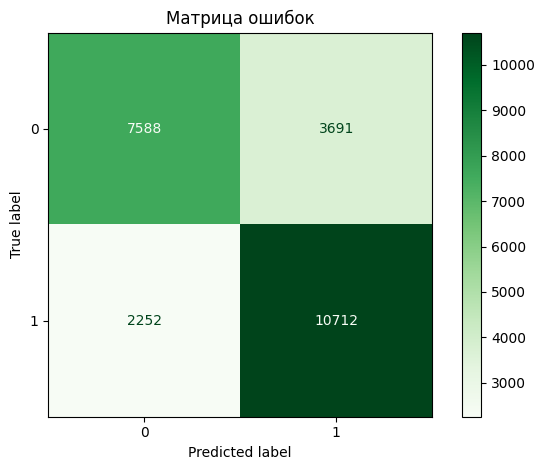

In [17]:
def metrics_class(true, predict):
    print(f'Метрики Логистической регрессии для классификации: \n'
          f'Accuracy - {accuracy_score(true, predict)} \n'
          f'f1 - {f1_score(true, predict)}\n')

    matrix = confusion_matrix(true, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(cmap='Greens', values_format='d')
    plt.title('Матрица ошибок')
    plt.tight_layout()
    plt.show()

metrics_class(y_test_classification, classification_predict)

##### Метрики для бинарной классификации оказались следующими:
- Accuracy - 0.75 Прекрасный результат для базовой модели Логистической регрессии, предсказала 75% правильно ещё на базовом бейзлайне
- f1 - 0.78 также прекрасный результат для такой слабой модели.
##### Так же выведена матрица ошибок, на которой видно, что модель предсказала единицу правильно куда чаще чем 0

In [20]:
def metric_reg(true, predict):
        print(f'Метрики Линейной регрессии: \n'
          f'MAE - {mean_absolute_error(true, predict)} \n'
          f'R^2 - {r2_score(true, predict)}\n'
          f'RMSE - {np.sqrt(mean_squared_error(true, predict))}\n')
metric_reg(y_test_reg, reg_predict)

Метрики Линейной регрессии: 
MAE - 0.020824230294451487 
R^2 - 0.9999999449039877
RMSE - 0.0359770895113429



Метрики регрессии все показали себя просто превосходно, что даже подозрительно, данные метрики говорят, что модель можно сказать Идеально предсказала целевую переменную. В прошлой работе мы смотрели на линейную зависимость целевой с другими признакми и увидели явную линейную зависимость. Скорее всего в данных есть утечка целевой переменной, поэтому в дальшейнейм бейзлайне удалим подозрительные признаки и проверим работу модели ещё раз. (Корреляция признака в 0.82 не может показать R^2 = 0.9999, это слишком подозрительно для базовой линейной модели) 

## 3.Улучшение бейзлайна

В первой работе мы уже посмотрели всё что нам было интересно связанное с данными и точно знаем что нужно делать для улучшения качества.
- применим кросс-валидацию к модели
- подберём к ней гиперпараметры через GridSreachCV.
- нормализируем данные, применим StandartScaler
- удалим подозрительные признаки с мультиколлинерностью из данных регрессии
- Используем Регуляризацию на Линейной регрессии, тк есть подозрения на переобучение

### Применим Scaler к данным регресии и найдём гиперпараметры модели с кросс-валидацией

#### Удаление данных с мультиколлинерностью и масштабирование

В данной лабораторной не будем использовать Масштабирование к Классификации, тк большенство наших признаков это бинарные значения.

In [30]:
columns_to_drop = [col for col in data_reg.columns if 'Fat' in col]
X_train_reg_without_Fats = X_train_reg.drop(columns=columns_to_drop)

columns_to_drop = [col for col in data_reg.columns if 'Fat' in col]
X_test_reg_without_Fats = X_test_reg.drop(columns=columns_to_drop)

scaler_reg = StandardScaler()

X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg_without_Fats)
X_test_reg_scaled = scaler_reg.transform(X_test_reg_without_Fats)

Использовали StandartScaler на данных именно после train_test_split чтобы не произошло утечки данных в тестовую выборку. Далее подберём гиперпараметры к моделям с кросс-валидацией
1. Параметры для Логистической регресси:
- C - сила регуляризации (меньше = сильнее регуляризация)
- penalty - тип регуляризации (L1, L2)
- solver - это алгоритм оптимизации, который ищет оптимальные веса (коэффициенты) для логистической регрессии.
  
2. Параметры для Линейной регрессии (тут можно было бы попробовать использовать Полиномиальную регрессию, но данные слишком хорошо выглядят для базовой)
- fit_intercept - включать ли свободный член (intercept)
- positive - ограничение коэффициентов только положительными значениями

In [74]:
log_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'max_iter': [50, 100, 200, 300]
}

lin_reg_params = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

model_class = LogisticRegression()
grid_class = GridSearchCV(estimator=model_class, param_grid=log_params,cv=8) 

model_reg = Lasso()
grid_reg = GridSearchCV(estimator=model_reg, param_grid=lin_reg_params, cv=8)

Logictic_class = grid_class.fit(X_train_classification, y_train_classification)
Linear_reg = grid_reg.fit(X_train_reg_scaled, y_train_reg)

После подбора гиперпараметров и обучения моделей, выведем метрики на экран и сравним их с прошлым бейзлайном

Метрики Логистической регрессии для классификации: 
Accuracy - 0.7547333250835293 
f1 - 0.7827865858113539



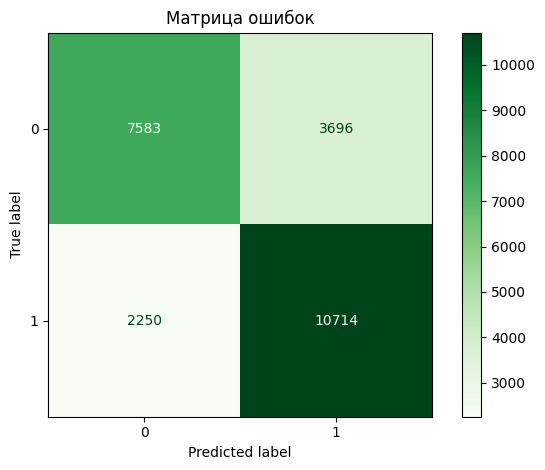

Метрики Линейной регрессии: 
MAE - 2.3632773669574734 
R^2 - 0.9916560787652522
RMSE - 14.00074162341076



In [76]:
predict_class = Logictic_class.predict(X_test_classification)
predict_reg = Linear_reg.predict(X_test_reg_scaled)

metrics_class(y_test_classification, predict_class)
metric_reg(y_test_reg, predict_reg)

##### Метрики на классификации толком не поменялись, что может означать, что Логистическая регрессия так и не смогла подобрать лучше параметры для данных, но это всё равно успешный, хороший результат
- Accuracy - 0.75
- f1 - 0.78
##### С регрессией ситуация куда интереснее, изначально метрики были слишком низкие, и это вызывало сильные подозрения, но после уделения Мультиколлинеарности (которой так боятся линейные модели) всё стало уже куда лучше
- MAE - 2.36
- R^2 - 0.991
- RMSE - 14.00
##### Это всё ещё очень высокий показатель работы модели, но он уже не вызывает так много вопросов как было раньше, данные в Регрессии очень линейны и мы это заметили ещё в первой лабораторной работе

# 4.Имплементация алгоритма машинного обучения 

Будем создавать две модели. Первая - Линейная регрессия для задачи Регрессии и Логистическая регрессия для задачи Классификации

In [39]:
import numpy as np
import pandas as pd

class LinearRegressionCustom:
    def __init__(self):
        self.weights = None

    def _to_numpy(self, X):
        # Оставляем только числовые признаки
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.select_dtypes(include=[np.number])
        return np.asarray(X, dtype=float)

    def _add_bias(self, X):
        # Добавляем столбец единиц: [1, x1, x2, ...]
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def fit(self, X, y):
        X = self._to_numpy(X)
        y = np.asarray(y, dtype=float)

        X = self._add_bias(X)

        # Решаем нормальным уравнением — w = (X^T X)^(-1) X^T y
        XtX = X.T @ X

        # Если XtX необратима — используем псевдообратную
        try:
            X_inv = np.linalg.inv(XtX)
        except np.linalg.LinAlgError:
            X_inv = np.linalg.pinv(XtX)

        self.weights = X_inv @ X.T @ y
        return self

    def predict(self, X):
        X = self._to_numpy(X)
        X = self._add_bias(X)
        return X @ self.weights


Модель Линейрной регрессии готова, далее Логистическая регрессия

In [41]:
import numpy as np
import pandas as pd

class LogisticRegressionCustom:
    def __init__(self, learning_rate=0.01, n_iter=1000, regularization=0.1, verbose=False):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.regularization = regularization  # L2 регуляризация
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def _sigmoid(self, x):
        # Стабильная версия сигмоиды
        return np.where(x >= 0, 
                       1 / (1 + np.exp(-x)), 
                       np.exp(x) / (1 + np.exp(x)))
    
    def _binary_cross_entropy(self, y_true, y_pred):
        # Добавляем epsilon для численной стабильности
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def fit(self, X, y):
        # Преобразуем в numpy arrays
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y.values if isinstance(y, pd.Series) else y
        
        n_samples, n_features = X.shape
        
        # Инициализация с маленькими случайными значениями вместо нулей
        self.weights = np.random.normal(0, 0.01, n_features)
        self.bias = 0
        
        # Масштабирование признаков (важно!)
        self.X_mean = np.mean(X, axis=0)
        self.X_std = np.std(X, axis=0) + 1e-8  # избегаем деления на 0
        X = (X - self.X_mean) / self.X_std
        
        for i in range(self.n_iter):
            # Прямое распространение
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)
            
            # Вычисление градиентов с регуляризацией
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y)) + (self.regularization / n_samples) * self.weights
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Логирование потерь
            if self.verbose and i % 100 == 0:
                loss = self._binary_cross_entropy(y, y_predicted)
                self.loss_history.append(loss)
                print(f"Iteration {i}, Loss: {loss:.4f}")
                
                # Проверяем баланс предсказаний
                pred_classes = (y_predicted > 0.5).astype(int)
                print(f"Class distribution: {np.bincount(pred_classes)}")
        
        return self
    
    def predict_proba(self, X):
        """Возвращает вероятности"""
        X = X.values if isinstance(X, pd.DataFrame) else X
        X = (X - self.X_mean) / self.X_std  # применяем то же масштабирование
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        """Предсказание классов"""
        probabilities = self.predict_proba(X)
        return (probabilities > threshold).astype(int)

Далее заведём модели и обучим их на базовом бейзлайне

In [43]:
class_model = LogisticRegressionCustom()
reg_model = LinearRegressionCustom()

class_model.fit(X_train_classification, y_train_classification)
reg_model.fit(X_train_reg, y_train_reg)

Выведем наши метрики и сравним

Метрики Логистической регрессии для классификации: 
Accuracy - 0.9370952439879553 
f1 - 0.9394865283123685



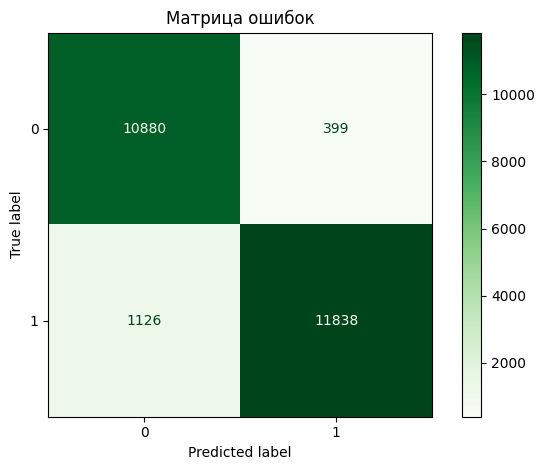

Метрики Линейной регрессии: 
MAE - 0.020824230296162805 
R^2 - 0.9999999449039877
RMSE - 0.03597708951305949



In [44]:
pred_class = class_model.predict(X_test_classification)
pred_reg = reg_model.predict(X_test_reg)

metrics_class(y_test_classification, pred_class)
metric_reg(y_test_reg, pred_reg)

Наша собственная модель Логистической регрессии на Базовом бейзлайне
- Accuracy - 0.93 Модель показала себя просто превосходно, доля верных предсказанных значений выросла почти на 0.15, что я является превосходным результатом
- f1 - 0.93 С метрикой для дисбаланса классов ситуация та же, модель показала себя стойко.
- По матрице ошибок можно заметить, что мы ошиблись всего лишь 1126 раза в 0 и 399 в 1, видим прекрасный результат.

В обучении модели Линейной регрессии на базовом бейзлайне видим явное переобучение модели.
- MAE - 0.02 
- R^2 - 0.999999 Слишком подозрительное значение для базовой линейной регрессии, что мы наблюдали и у модели sklearn
- RMSE - 0.035

Далее заведём наши модели на новом бейзлайне, постараемся ещё улучшить показатели Логистической регрессии, но не довести её до переобучения, а так же избавимся от мультиколлинерности в линейной регрессии

Возьмём гиперпараметры для модели из модели sklearn, чтобы не искать их заново

In [82]:
print(f'Лучшие параметры для задачи регрессии:{grid_class.best_params_}')

Лучшие параметры для задачи регрессии:{'C': 10, 'max_iter': 300, 'penalty': 'l2'}


После подбора гиперпараметров заведём нашу модель и обучим её вместе с ними, так же и обучим линейную регрессию на новом бейзлайне и сверим метрики.

Метрики Логистической регрессии для классификации: 
Accuracy - 0.9839953801097224 
f1 - 0.9849038985292974



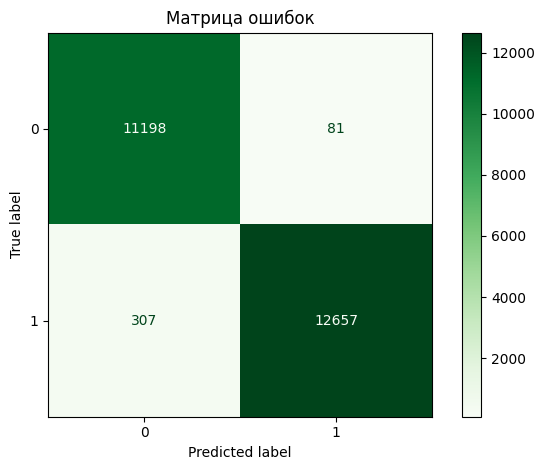

Метрики Линейной регрессии: 
MAE - 1.8687527102353978 
R^2 - 0.9921885621807603
RMSE - 13.546635117852182



In [85]:
class_model_second = LogisticRegressionCustom(learning_rate=0.1, n_iter=grid_class.best_params_['max_iter'])
class_model_second.fit(X_train_classification, y_train_classification)

reg_model_second = LinearRegressionCustom()
reg_model_second.fit(X_train_reg_scaled, y_train_reg)

predict_reg = reg_model_second.predict(X_test_reg_scaled)
predict_class = class_model_second.predict(X_test_classification)

metrics_class(y_test_classification, predict_class)
metric_reg(y_test_reg, predict_reg)

Метрики для нашей Логистической регрессии - классификация в новом бейзлайне:
- Accuracy - 0.983 
- f1 - 0.984
##### Данная модель пока показала Лучшие метрики, она не выглядит как переобученная и в тоже время является довольно лёгкой моделью, ведь в подборе гиперпараметров было поставлено максимум итераци - 600

Метрики для нашей Линейной регрессии в новом бейзлайне:
- MAE - 1.86 
- R^2 - 0.99 
- RMSE - 13.54
##### Метрики вновь показывают идентичную ситуацию, как было и с модель sklearn, немного смогли избавиться от переобучения модели

# Вывод по проделанной работе

В ходе лабораторной работы мы научились работать с такими моделями как - Логистическая регрессия для бинарной классификации и Линейная регрессия для задач регрессии. Для начала взяли модели из sklearn и обучили их на первом бейзлайне, сразу было заметно, что Линейная регрессия переобучается, поэтому было решено удалить Мультиколлинеарность из данных, которые мы заметили ещё в первой лабораторной работе. Далее на новом бейзлайне Логистическая регрессия так и не показала каких то отличительных результатов, но Линейная регрессия чуток избавилась от переобучения. Далее были написаны собственные модели и уже на первом бейзлайне было заметно явное превосходство Логистической регрессии, Линейная же повела себя идентично модели из sklearn. Далее на новом бейзлайне Логистическая регрессия показала феноминальный результат в долю правильно предсказанных 0.98, а так же Линейная регрессия немного избавилась от переобучения.